In [9]:
import os
import sys

sys.path.append("..")

from itertools import product
from lightgbm import LGBMRanker
from sklearn.utils import check_random_state
from xai_ranking.benchmarks import (
    human_in_the_loop_experiment,
    human_in_the_loop_batch_experiment,
    hierarchical_ranking_explanation,
    hierarchical_ranking_batch_explanation,
    lime_experiment,
    lime_batch_experiment,
    shap_experiment,
    shap_batch_experiment,
    sharp_experiment,
    sharp_batch_experiment,
    # participation_experiment,
)
from xai_ranking.preprocessing import (
    preprocess_atp_data,
    preprocess_csrank_data,
    preprocess_higher_education_data,
    preprocess_movers_data,
    preprocess_synthetic_data,
)
from xai_ranking.datasets import (
    fetch_atp_data,
    fetch_csrank_data,
    fetch_higher_education_data,
    fetch_movers_data,
    fetch_synthetic_data,
)
from xai_ranking.scorers import (
    atp_score,
    csrank_score,
    higher_education_score,
    synthetic_equal_score_3ftrs,
)
from xai_ranking.metrics import (
    explanation_sensitivity,
    outcome_sensitivity,
    bootstrapped_explanation_consistency,
    cross_method_explanation_consistency,
    cross_method_outcome_consistency,
    outcome_fidelity,
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlresearch.utils import check_random_states, set_matplotlib_style
from sharp.utils import scores_to_ordering

RNG_SEED = 42

In [10]:
# Set up ranker for the moving company dataset:
X, ranks, score = preprocess_movers_data(fetch_movers_data(test=False))
qids_train = X.index.value_counts().to_numpy()

model = LGBMRanker(
    objective="lambdarank", label_gain=list(range(max(ranks) + 1)), verbose=-1
)
model.fit(
    X=X,
    y=ranks,
    group=qids_train,
)

LGBMRanker(label_gain=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
           objective='lambdarank', verbose=-1)

In [37]:
datasets = [
    {
        "name": "ATP",
        "data": preprocess_atp_data(fetch_atp_data()),
        "scorer": atp_score,
        "done": True,
    },
    {
        "name": "CSRank",
        "data": preprocess_csrank_data(fetch_csrank_data()),
        "scorer": csrank_score,
        "done": True,
    },
    {
        "name": "Higher Education",
        "data": preprocess_higher_education_data(
            fetch_higher_education_data(year=2020)
        ),
        "scorer": higher_education_score,
        "done": True,
    },
    {
        "name": "Synthetic_2",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=2, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
        "done": True
    },
    {
        "name": "Synthetic_1",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=1, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
        "done": True
    },
    {
        "name": "Synthetic_0",
        "data": preprocess_synthetic_data(
            fetch_synthetic_data(synth_dt_version=0, item_num=2000)
        ),
        "scorer": synthetic_equal_score_3ftrs,
        "n_observations": 100,
        "done": True
    },
    # {
    #     "name": "Moving Company",
    #     "data": preprocess_movers_data(fetch_movers_data(test=True)),
    #     "scorer": model.predict,
    #     "done": True,
    # },
]
xai_methods = [
    {
        "iterations": 1,
        "name": "rank",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
            "qoi": "rank"
        },
        "done": True,
    },
    {
        "iterations": 1,
        "name": "score",
        "experiment": sharp_experiment,
        "kwargs": {
            "verbose": True,
            "sample_size": None,
            "measure": "shapley",
            "n_jobs": -1,
            "replace": False,
            "qoi": "rank_score"
        },
        "done": True,
    },
]


In [45]:
def read_results_from_files():
    return_dict = {}
    for cur_dataset in datasets:
        return_dict[cur_dataset["name"]] = {}
        for cur_xai_method in xai_methods:
            return_dict[cur_dataset["name"]][cur_xai_method["name"]] = []
            for iteration in range(cur_xai_method["iterations"]):
                fname = (
                    f"results/time-experiment-"
                    f"{cur_dataset['name']}_{cur_xai_method['name']}.csv"
                )
                if os.path.isfile(fname):
                    (
                        return_dict[cur_dataset["name"]][cur_xai_method["name"]].append(
                            pd.read_csv(fname, index_col=0)
                        )
                    )
    return return_dict

In [46]:
results = read_results_from_files()

In [47]:
results

{'ATP': {'rank': [   dataset  n_observations approach       parameter  parameter_value  \
   0      ATP              86     rank             NaN              NaN   
   1      ATP              86     rank  coalition_size              1.0   
   2      ATP              86     rank  coalition_size              2.0   
   3      ATP              86     rank  coalition_size              3.0   
   4      ATP              86     rank  coalition_size              4.0   
   5      ATP              86     rank  coalition_size              5.0   
   6      ATP              86     rank     sample_size             20.0   
   7      ATP              86     rank     sample_size             50.0   
   8      ATP              86     rank          n_jobs              1.0   
   9      ATP              86     rank          n_jobs              2.0   
   10     ATP              86     rank          n_jobs              4.0   
   11     ATP              86     rank          n_jobs              8.0   
   12     

# Time vs Threads

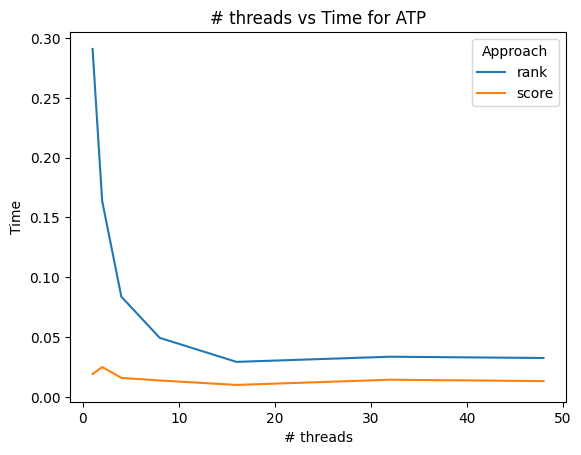

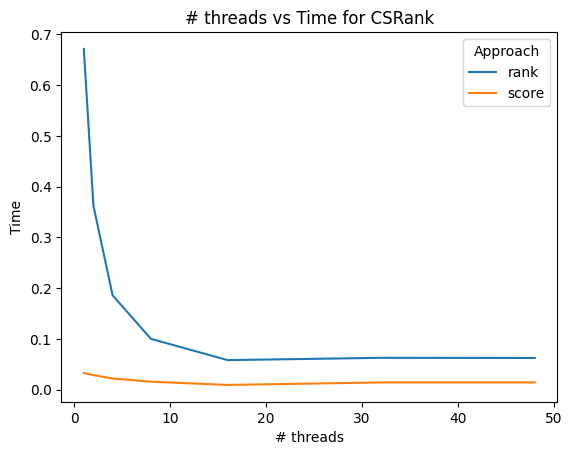

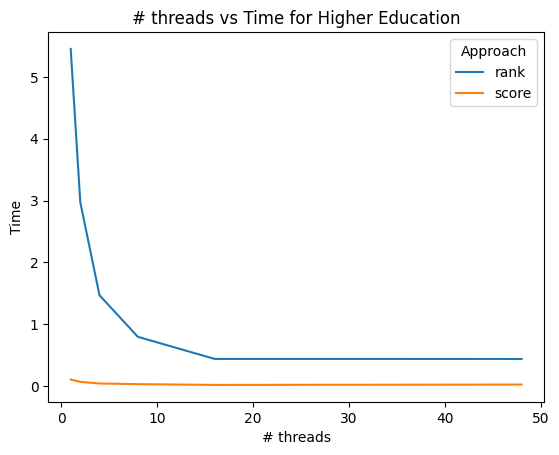

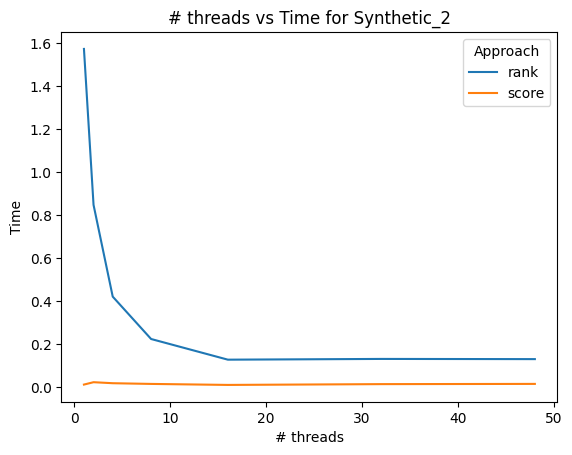

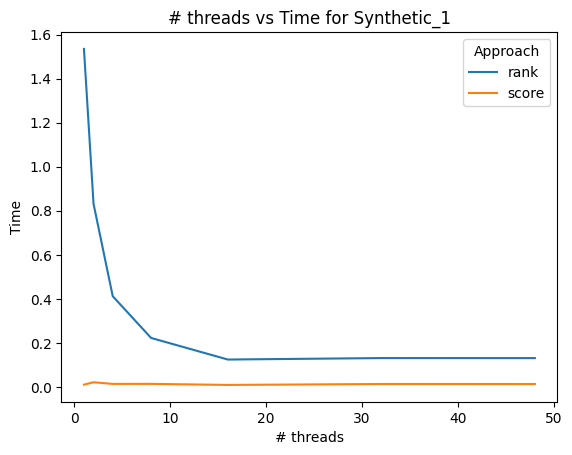

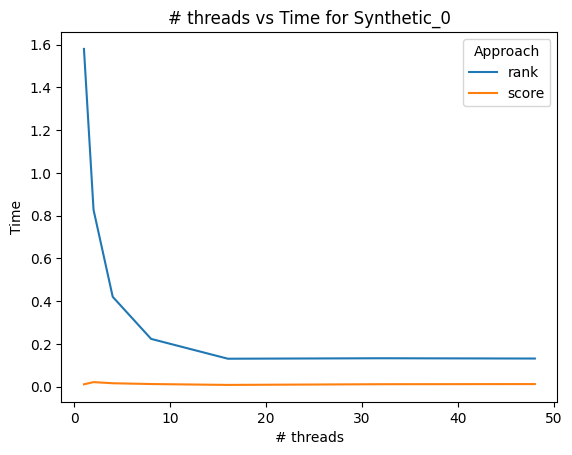

In [58]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

for dataset in datasets:
    df = pd.DataFrame()
    
    for method in methods:
        # Make dataset that contains all methods together (if run each QoI separately)
        df = pd.concat([df,results[dataset["name"]][method][0]])
        df = df.replace("rank_score", "score")
        # Make the time per point
        df["time"] = df["time_0"] / 100

    # Make one plot per dataset
    df_threads = df[df["parameter"]=="n_jobs"]

    sns.lineplot(data=df_threads, x="parameter_value", y="time", hue="approach")
    plt.xlabel('# threads')
    plt.ylabel('Time')
    plt.title(f'# threads vs Time for {dataset["name"]}')
    plt.legend(title='Approach')

    plt.savefig(
            f"results/time-experiment-threadsVStime-{dataset["name"]}.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True
            )
    
    plt.show()

# Coalition Size vs Metrics

/state/partition1/job-48952899/ipykernel_2811468/475832002.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coals['average_fidelity'] = df_coals[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
/state/partition1/job-48952899/ipykernel_2811468/475832002.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coals['average_agreement_kendall'] = df_coals[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_kendall_4'

  dataset  n_observations approach       parameter  parameter_value  avg_time  \
1     ATP              86     rank  coalition_size              1.0  0.553096   
2     ATP              86     rank  coalition_size              2.0  1.333951   
3     ATP              86     rank  coalition_size              3.0  2.090682   
4     ATP              86     rank  coalition_size              4.0  2.456866   
5     ATP              86     rank  coalition_size              5.0  2.526613   
1     ATP              86    score  coalition_size              1.0  0.116131   
2     ATP              86    score  coalition_size              2.0  0.199607   
3     ATP              86    score  coalition_size              3.0  0.282446   
4     ATP              86    score  coalition_size              4.0  0.311409   
5     ATP              86    score  coalition_size              5.0  0.329528   

     time_0    time_1    time_2    time_3  ...  agreement_euclidean_4  \
1  0.557471  0.549116  0.549529  0.

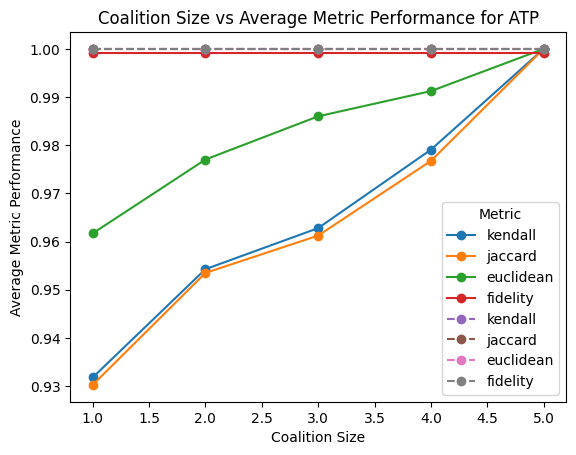

/state/partition1/job-48952899/ipykernel_2811468/475832002.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coals['average_fidelity'] = df_coals[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
/state/partition1/job-48952899/ipykernel_2811468/475832002.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coals['average_agreement_kendall'] = df_coals[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_kendall_4'

  dataset  n_observations approach       parameter  parameter_value  avg_time  \
1  CSRank             100     rank  coalition_size              1.0  1.918995   
2  CSRank             100     rank  coalition_size              2.0  4.029942   
3  CSRank             100     rank  coalition_size              3.0  5.430236   
4  CSRank             100     rank  coalition_size              4.0  5.728710   
1  CSRank             100    score  coalition_size              1.0  0.210555   
2  CSRank             100    score  coalition_size              2.0  0.333545   
3  CSRank             100    score  coalition_size              3.0  0.421361   
4  CSRank             100    score  coalition_size              4.0  0.445659   

     time_0    time_1    time_2    time_3  ...  agreement_euclidean_4  \
1  1.924122  1.934719  1.927526  1.881052  ...               0.901019   
2  4.067352  3.956354  3.955341  4.120541  ...               0.935949   
3  5.427330  5.345304  5.419416  5.498272  ...     

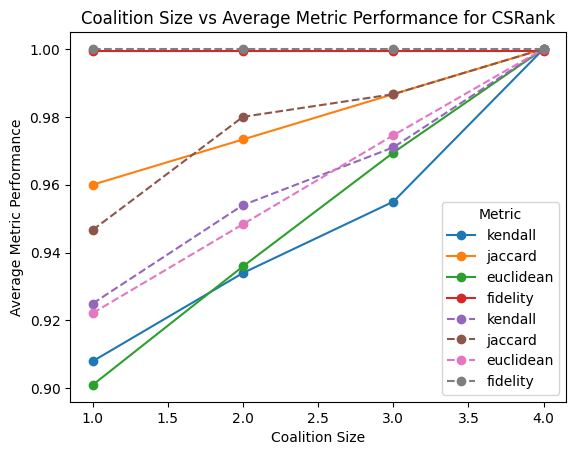

/state/partition1/job-48952899/ipykernel_2811468/475832002.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coals['average_fidelity'] = df_coals[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
/state/partition1/job-48952899/ipykernel_2811468/475832002.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coals['average_agreement_kendall'] = df_coals[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_kendall_4'

            dataset  n_observations approach       parameter  parameter_value  \
1  Higher Education             100     rank  coalition_size              1.0   
2  Higher Education             100     rank  coalition_size              2.0   
3  Higher Education             100     rank  coalition_size              3.0   
4  Higher Education             100     rank  coalition_size              4.0   
1  Higher Education             100    score  coalition_size              1.0   
2  Higher Education             100    score  coalition_size              2.0   
3  Higher Education             100    score  coalition_size              3.0   
4  Higher Education             100    score  coalition_size              4.0   

    avg_time     time_0     time_1     time_2     time_3  ...  \
1  14.280344  14.178541  14.262787  14.295090  14.362383  ...   
2  31.148204  31.119789  31.216528  31.023720  31.228584  ...   
3  42.376886  42.568041  42.586615  42.334655  42.180889  ...   
4  45.3138

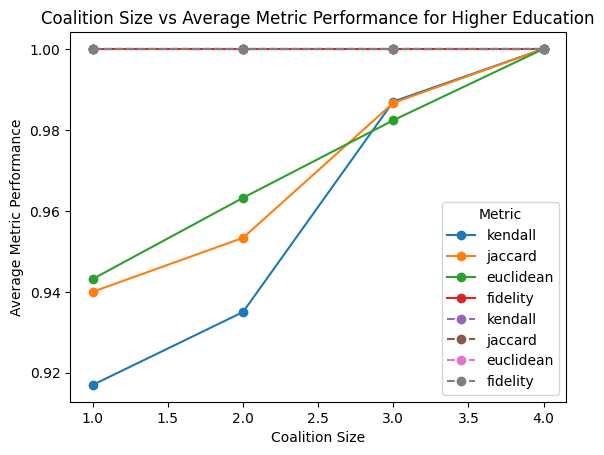

/state/partition1/job-48952899/ipykernel_2811468/475832002.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coals['average_fidelity'] = df_coals[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
/state/partition1/job-48952899/ipykernel_2811468/475832002.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coals['average_agreement_kendall'] = df_coals[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_kendall_4'

       dataset  n_observations approach       parameter  parameter_value  \
1  Synthetic_2             100     rank  coalition_size              1.0   
2  Synthetic_2             100     rank  coalition_size              2.0   
1  Synthetic_2             100    score  coalition_size              1.0   
2  Synthetic_2             100    score  coalition_size              2.0   

    avg_time     time_0     time_1     time_2     time_3  ...  \
1   9.605628   9.577917   9.660489   9.597910   9.530267  ...   
2  12.850375  12.899098  12.785439  12.946933  12.808110  ...   
1   0.163216   0.149919   0.165389   0.178662   0.170424  ...   
2   0.210823   0.206758   0.208747   0.207211   0.219348  ...   

   agreement_euclidean_4  fidelity_0  fidelity_1  fidelity_2  fidelity_3  \
1               0.975144         1.0         1.0         1.0         1.0   
2               1.000000         1.0         1.0         1.0         1.0   
1               1.000000         1.0         1.0         1.0     

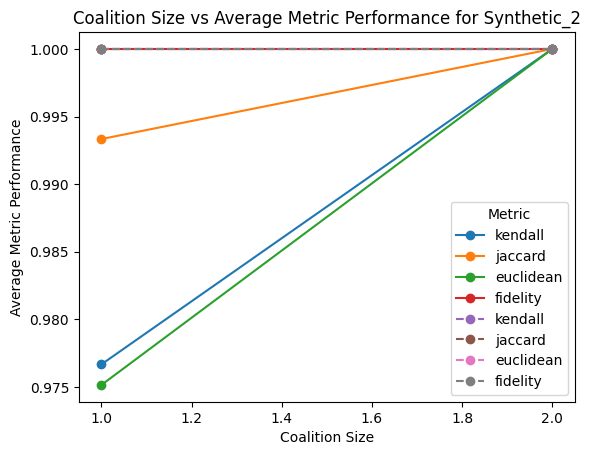

/state/partition1/job-48952899/ipykernel_2811468/475832002.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coals['average_fidelity'] = df_coals[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
/state/partition1/job-48952899/ipykernel_2811468/475832002.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coals['average_agreement_kendall'] = df_coals[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_kendall_4'

       dataset  n_observations approach       parameter  parameter_value  \
1  Synthetic_1             100     rank  coalition_size              1.0   
2  Synthetic_1             100     rank  coalition_size              2.0   
1  Synthetic_1             100    score  coalition_size              1.0   
2  Synthetic_1             100    score  coalition_size              2.0   

    avg_time     time_0     time_1     time_2     time_3  ...  \
1   9.625827   9.604714   9.590926   9.637520   9.615329  ...   
2  12.807912  12.784675  12.751408  12.873206  12.846914  ...   
1   0.170137   0.169026   0.177988   0.166807   0.167939  ...   
2   0.210768   0.209631   0.213598   0.210880   0.208560  ...   

   agreement_euclidean_4  fidelity_0  fidelity_1  fidelity_2  fidelity_3  \
1               0.961924         1.0         1.0         1.0         1.0   
2               1.000000         1.0         1.0         1.0         1.0   
1               1.000000         1.0         1.0         1.0     

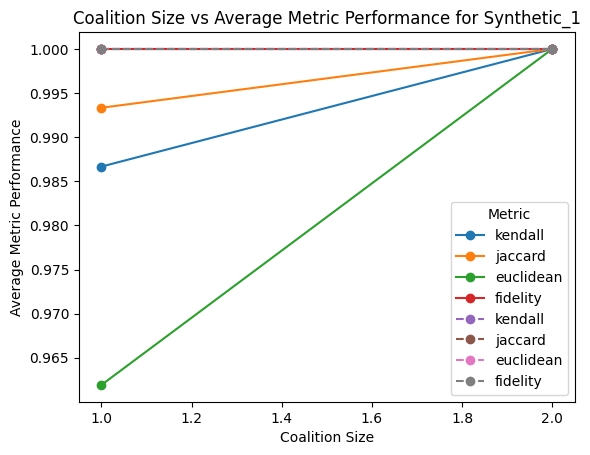

/state/partition1/job-48952899/ipykernel_2811468/475832002.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coals['average_fidelity'] = df_coals[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
/state/partition1/job-48952899/ipykernel_2811468/475832002.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_coals['average_agreement_kendall'] = df_coals[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_kendall_4'

       dataset  n_observations approach       parameter  parameter_value  \
1  Synthetic_0             100     rank  coalition_size              1.0   
2  Synthetic_0             100     rank  coalition_size              2.0   
1  Synthetic_0             100    score  coalition_size              1.0   
2  Synthetic_0             100    score  coalition_size              2.0   

    avg_time     time_0     time_1     time_2     time_3  ...  \
1   9.816586   9.807789   9.875772   9.758194   9.856505  ...   
2  13.099317  13.119361  13.135697  13.040579  13.140623  ...   
1   0.160227   0.149074   0.164605   0.159164   0.166399  ...   
2   0.221069   0.217232   0.217488   0.228878   0.220602  ...   

   agreement_euclidean_4  fidelity_0  fidelity_1  fidelity_2  fidelity_3  \
1               0.977131         1.0         1.0         1.0         1.0   
2               1.000000         1.0         1.0         1.0         1.0   
1               1.000000         1.0         1.0         1.0     

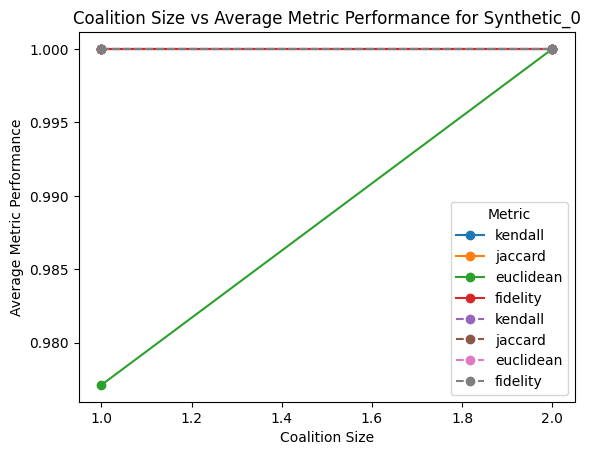

In [78]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

for dataset in datasets:
    df = pd.DataFrame()
    
    for method in methods:
        # Make dataset that contains all methods together (if run each QoI separately)
        df = pd.concat([df,results[dataset["name"]][method][0]])
        df = df.replace("rank_score", "score")

    # Make one plot per dataset
    df_coals = df[df["parameter"]=="coalition_size"]

    # average fidelity
    df_coals['average_fidelity'] = df_coals[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
    
    # average agreement
    df_coals['average_agreement_kendall'] = df_coals[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_kendall_4']].mean(axis=1)
    df_coals['average_agreement_jaccard'] = df_coals[['agreement_jaccard2_0', 'agreement_jaccard2_1', 'agreement_jaccard2_2', 'agreement_jaccard2_3', 'agreement_jaccard2_4']].mean(axis=1)
    df_coals['average_agreement_euclidean'] = df_coals[['agreement_euclidean_0', 'agreement_euclidean_1', 'agreement_euclidean_2', 'agreement_euclidean_3', 'agreement_euclidean_4']].mean(axis=1)

    print(df_coals)
    # Rank lines
    for agreement in ['kendall', 'jaccard', 'euclidean']:
        plt.plot(df_coals[df_coals["approach"]=="rank"]['parameter_value'], df_coals[df_coals["approach"]=="rank"][f'average_agreement_{agreement}'], marker='o', label=agreement)

    plt.plot(df_coals[df_coals["approach"]=="rank"]['parameter_value'], df_coals[df_coals["approach"]=="rank"]['average_fidelity'], marker='o', label='fidelity')

    # Score lines
    for agreement in ['kendall', 'jaccard', 'euclidean']:
        plt.plot(df_coals[df_coals["approach"]=="score"]['parameter_value'], df_coals[df_coals["approach"]=="score"][f'average_agreement_{agreement}'], marker='o', label=agreement, linestyle='--')

    plt.plot(df_coals[df_coals["approach"]=="score"]['parameter_value'], df_coals[df_coals["approach"]=="score"]['average_fidelity'], marker='o', label='fidelity', linestyle='--')

    
    plt.xlabel('Coalition Size')
    plt.ylabel('Average Metric Performance')
    plt.title(f'Coalition Size vs Average Metric Performance for {dataset["name"]}')
    plt.legend(title='Metric')
    
    # plt.xticks(coalition_data['parameter_value'].unique().astype(int))

    plt.savefig(
            f"results/time-experiment-coalitions-{dataset["name"]}.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True
            )
    
    plt.show()

# Sample size vs Metrics

/state/partition1/job-48952899/ipykernel_2811468/3347061788.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['average_fidelity'] = df_samples[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
/state/partition1/job-48952899/ipykernel_2811468/3347061788.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['average_agreement_kendall'] = df_samples[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_

  dataset  n_observations approach    parameter  parameter_value  avg_time  \
6     ATP              86     rank  sample_size             20.0  0.792815   
7     ATP              86     rank  sample_size             50.0  1.627761   
6     ATP              86    score  sample_size             20.0  0.204641   
7     ATP              86    score  sample_size             50.0  0.276012   

     time_0    time_1    time_2    time_3  ...  agreement_euclidean_4  \
6  0.786834  0.796464  0.800710  0.803082  ...               0.966855   
7  1.581238  1.666616  1.655434  1.618935  ...               0.984121   
6  0.198995  0.207906  0.209610  0.200436  ...               0.961304   
7  0.262426  0.290215  0.269444  0.277718  ...               0.983832   

   fidelity_0  fidelity_1  fidelity_2  fidelity_3  fidelity_4  \
6    0.999217    0.999217    0.999217    0.999217    0.999217   
7    0.999217    0.999217    0.999217    0.999217    0.999217   
6    1.000000    1.000000    1.000000    1.00000

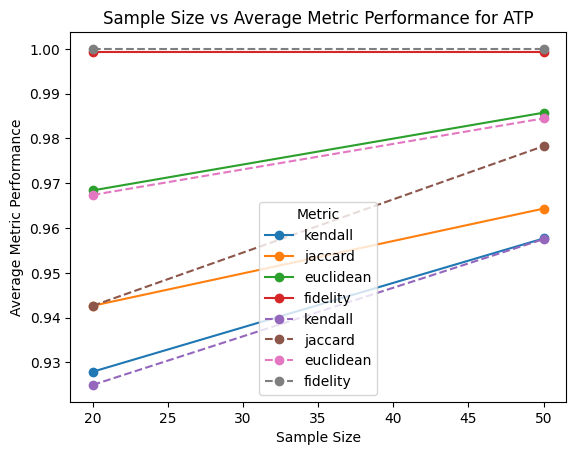

/state/partition1/job-48952899/ipykernel_2811468/3347061788.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['average_fidelity'] = df_samples[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
/state/partition1/job-48952899/ipykernel_2811468/3347061788.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['average_agreement_kendall'] = df_samples[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_

  dataset  n_observations approach    parameter  parameter_value  avg_time  \
5  CSRank             100     rank  sample_size             20.0  0.808337   
6  CSRank             100     rank  sample_size             50.0  1.665623   
7  CSRank             100     rank  sample_size            100.0  3.070510   
5  CSRank             100    score  sample_size             20.0  0.189009   
6  CSRank             100    score  sample_size             50.0  0.252692   
7  CSRank             100    score  sample_size            100.0  0.314629   

     time_0    time_1    time_2    time_3  ...  agreement_euclidean_4  \
5  0.790421  0.796796  0.825556  0.807964  ...               0.949281   
6  1.691263  1.689330  1.648876  1.652109  ...               0.971387   
7  3.017921  3.099164  3.041571  3.128557  ...               0.980106   
5  0.190191  0.176538  0.196287  0.189872  ...               0.946322   
6  0.260371  0.259710  0.248404  0.243467  ...               0.965551   
7  0.308011  0.

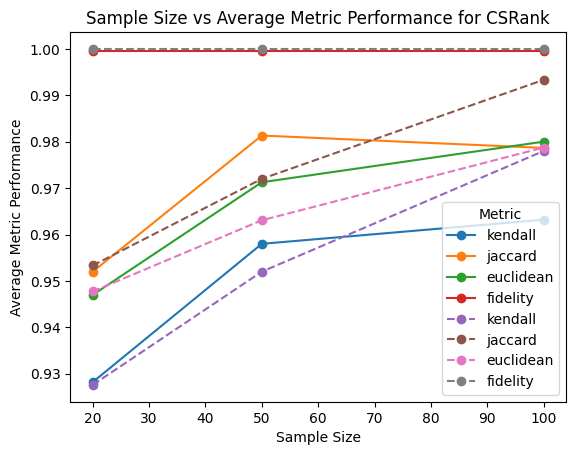

/state/partition1/job-48952899/ipykernel_2811468/3347061788.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['average_fidelity'] = df_samples[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
/state/partition1/job-48952899/ipykernel_2811468/3347061788.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['average_agreement_kendall'] = df_samples[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_

             dataset  n_observations approach    parameter  parameter_value  \
5   Higher Education             100     rank  sample_size             20.0   
6   Higher Education             100     rank  sample_size             50.0   
7   Higher Education             100     rank  sample_size            100.0   
8   Higher Education             100     rank  sample_size            250.0   
9   Higher Education             100     rank  sample_size            500.0   
10  Higher Education             100     rank  sample_size           1000.0   
5   Higher Education             100    score  sample_size             20.0   
6   Higher Education             100    score  sample_size             50.0   
7   Higher Education             100    score  sample_size            100.0   
8   Higher Education             100    score  sample_size            250.0   
9   Higher Education             100    score  sample_size            500.0   
10  Higher Education             100    score  sampl

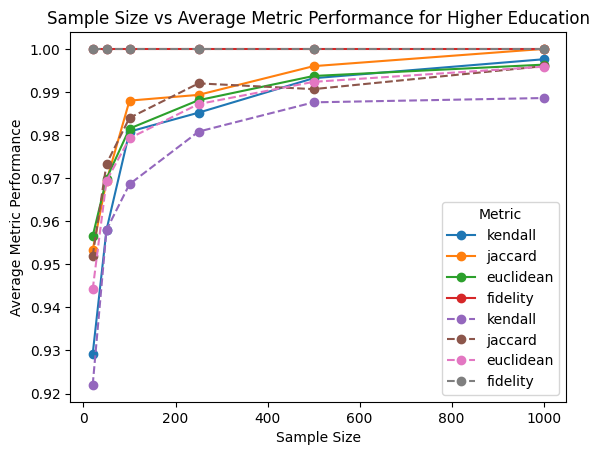

/state/partition1/job-48952899/ipykernel_2811468/3347061788.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['average_fidelity'] = df_samples[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
/state/partition1/job-48952899/ipykernel_2811468/3347061788.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['average_agreement_kendall'] = df_samples[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_

       dataset  n_observations approach    parameter  parameter_value  \
3  Synthetic_2             100     rank  sample_size             20.0   
4  Synthetic_2             100     rank  sample_size             50.0   
5  Synthetic_2             100     rank  sample_size            100.0   
6  Synthetic_2             100     rank  sample_size            250.0   
7  Synthetic_2             100     rank  sample_size            500.0   
8  Synthetic_2             100     rank  sample_size           1000.0   
9  Synthetic_2             100     rank  sample_size           1500.0   
3  Synthetic_2             100    score  sample_size             20.0   
4  Synthetic_2             100    score  sample_size             50.0   
5  Synthetic_2             100    score  sample_size            100.0   
6  Synthetic_2             100    score  sample_size            250.0   
7  Synthetic_2             100    score  sample_size            500.0   
8  Synthetic_2             100    score  sample_siz

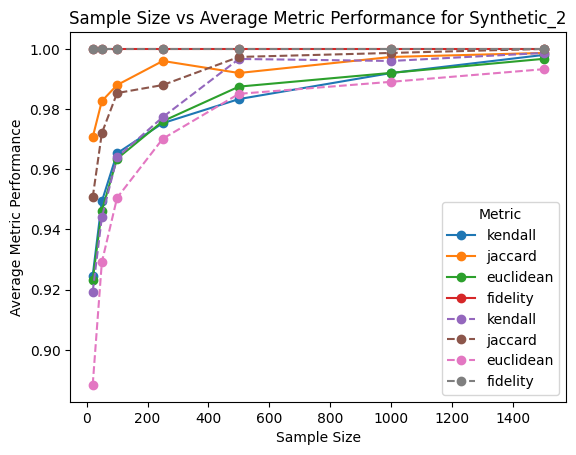

/state/partition1/job-48952899/ipykernel_2811468/3347061788.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['average_fidelity'] = df_samples[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
/state/partition1/job-48952899/ipykernel_2811468/3347061788.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['average_agreement_kendall'] = df_samples[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_

       dataset  n_observations approach    parameter  parameter_value  \
3  Synthetic_1             100     rank  sample_size             20.0   
4  Synthetic_1             100     rank  sample_size             50.0   
5  Synthetic_1             100     rank  sample_size            100.0   
6  Synthetic_1             100     rank  sample_size            250.0   
7  Synthetic_1             100     rank  sample_size            500.0   
8  Synthetic_1             100     rank  sample_size           1000.0   
9  Synthetic_1             100     rank  sample_size           1500.0   
3  Synthetic_1             100    score  sample_size             20.0   
4  Synthetic_1             100    score  sample_size             50.0   
5  Synthetic_1             100    score  sample_size            100.0   
6  Synthetic_1             100    score  sample_size            250.0   
7  Synthetic_1             100    score  sample_size            500.0   
8  Synthetic_1             100    score  sample_siz

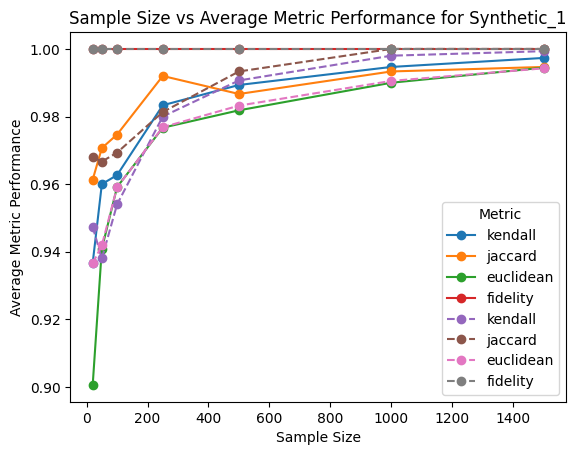

/state/partition1/job-48952899/ipykernel_2811468/3347061788.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['average_fidelity'] = df_samples[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
/state/partition1/job-48952899/ipykernel_2811468/3347061788.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['average_agreement_kendall'] = df_samples[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_

       dataset  n_observations approach    parameter  parameter_value  \
3  Synthetic_0             100     rank  sample_size             20.0   
4  Synthetic_0             100     rank  sample_size             50.0   
5  Synthetic_0             100     rank  sample_size            100.0   
6  Synthetic_0             100     rank  sample_size            250.0   
7  Synthetic_0             100     rank  sample_size            500.0   
8  Synthetic_0             100     rank  sample_size           1000.0   
9  Synthetic_0             100     rank  sample_size           1500.0   
3  Synthetic_0             100    score  sample_size             20.0   
4  Synthetic_0             100    score  sample_size             50.0   
5  Synthetic_0             100    score  sample_size            100.0   
6  Synthetic_0             100    score  sample_size            250.0   
7  Synthetic_0             100    score  sample_size            500.0   
8  Synthetic_0             100    score  sample_siz

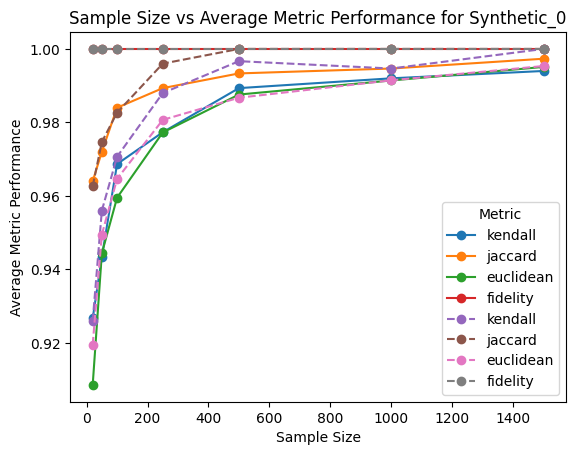

In [79]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

for dataset in datasets:
    df = pd.DataFrame()
    
    for method in methods:
        # Make dataset that contains all methods together (if run each QoI separately)
        df = pd.concat([df,results[dataset["name"]][method][0]])
        df = df.replace("rank_score", "score")

    # Make one plot per dataset
    df_samples = df[df["parameter"]=="sample_size"]

    # average fidelity
    df_samples['average_fidelity'] = df_samples[['fidelity_0', 'fidelity_1', 'fidelity_2', 'fidelity_3', 'fidelity_4']].mean(axis=1)
    
    # average agreement
    df_samples['average_agreement_kendall'] = df_samples[['agreement_kendall_0', 'agreement_kendall_1', 'agreement_kendall_2', 'agreement_kendall_3', 'agreement_kendall_4']].mean(axis=1)
    df_samples['average_agreement_jaccard'] = df_samples[['agreement_jaccard2_0', 'agreement_jaccard2_1', 'agreement_jaccard2_2', 'agreement_jaccard2_3', 'agreement_jaccard2_4']].mean(axis=1)
    df_samples['average_agreement_euclidean'] = df_samples[['agreement_euclidean_0', 'agreement_euclidean_1', 'agreement_euclidean_2', 'agreement_euclidean_3', 'agreement_euclidean_4']].mean(axis=1)

    print(df_samples)
    # Rank lines
    for agreement in ['kendall', 'jaccard', 'euclidean']:
        plt.plot(df_samples[df_samples["approach"]=="rank"]['parameter_value'], df_samples[df_samples["approach"]=="rank"][f'average_agreement_{agreement}'], marker='o', label=agreement)

    plt.plot(df_samples[df_samples["approach"]=="rank"]['parameter_value'], df_samples[df_samples["approach"]=="rank"]['average_fidelity'], marker='o', label='fidelity')

    # Score lines
    for agreement in ['kendall', 'jaccard', 'euclidean']:
        plt.plot(df_samples[df_samples["approach"]=="score"]['parameter_value'], df_samples[df_samples["approach"]=="score"][f'average_agreement_{agreement}'], marker='o', label=agreement, linestyle='--')

    plt.plot(df_samples[df_samples["approach"]=="score"]['parameter_value'], df_samples[df_samples["approach"]=="score"]['average_fidelity'], marker='o', label='fidelity', linestyle='--')

    
    plt.xlabel('Sample Size')
    plt.ylabel('Average Metric Performance')
    plt.title(f'Sample Size vs Average Metric Performance for {dataset["name"]}')
    plt.legend(title='Metric')
    
    # plt.xticks(coalition_data['parameter_value'].unique().astype(int))

    plt.savefig(
            f"results/time-experiment-samples-{dataset["name"]}.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True
            )
    
    plt.show()

# Time vs coalition size

In [ ]:
methods = [method for method in results["ATP"].keys() if not method.startswith("BATCH")]

for dataset in datasets:
    df = pd.DataFrame()
    
    for method in methods:
        # Make dataset that contains all methods together (if run each QoI separately)
        df = pd.concat([df,results[dataset["name"]][method][0]])
        df = df.replace("rank_score", "score")
        # Make the time per point
        df["time"] = df["time_0"] / 100

    # Make one plot per dataset
    df_threads = df[df["parameter"]=="sample_size"]

    sns.lineplot(data=df_threads, x="parameter_value", y="time", hue="approach")
    plt.xlabel('# threads')
    plt.ylabel('Time')
    plt.title(f'# threads vs Time for {dataset["name"]}')
    plt.legend(title='Approach')

    plt.savefig(
            f"results/time-experiment-samplesVStime-{dataset["name"]}.pdf",
            format="pdf",
            bbox_inches="tight",
            transparent=True
            )
    
    plt.show()